In [ ]:
import numpy as np
import scipy.stats
from functools import partial
# ! pip install emcee
# ! pip install cvxopt
# import emcee
# from cvxopt import matrix, solvers
import pandas as pd
import seaborn as sns
from scipy.special import logsumexp
# from multiprocessing import Pool
# from numba import jit


# !pip install scipy --upgrade
# pool=Pool(4)

# Utilities

In [ ]:
def gaussian_dist_sqrt(x,params):
  mu,L=params
  # print(x)
  # print(gaussian_dist(x,mu,L))
  return 0.5*gaussian_dist(x,mu,L)

def gaussian_dist(x,mu,L): # returns log gaussian
  d=len(mu)
  Linv=np.linalg.inv(L)
  # print(Linv)
  # print(-0.5*(x - mu)@(Linv@Linv.T)@(x-mu)[:,np.newaxis]-np.log(np.sqrt((np.linalg.det(L)**2)*(2*np.pi)**d)))
  return (-0.5*np.dot(np.dot((x - mu),(Linv.T@Linv)),(x-mu))-np.log(np.sqrt((np.linalg.det(L)**2)*(2*np.pi)**d)))

In [ ]:
def norm_innerproduct(a_mu, a_L, b_pdf, N=1000): # For gaussian and arbitrary distribution
  # draw N samples
  d=len(a_mu)
  x = a_mu[:,np.newaxis] + a_L@np.random.randn(d, N)

  # print(a_mu)
  # print(x)

  a_pdf_vec = np.apply_along_axis(gaussian_dist_sqrt,0,x,params=(a_mu,a_L))[0]
  b_pdf_vec = np.vectorize(b_pdf)

  b_pdf_x=np.apply_along_axis(b_pdf,0,x)[0]
  # print("b_pdf",b_pdf_x)
  # print("a_pdf",a_pdf_vec)

  ip_ab = np.logaddexp.reduce(b_pdf_x-a_pdf_vec)-np.log(N)
  # print("ip_ab",ip_ab)
  # return (1 - 1e-8) if ip_ab > 1 else ip_ab
  return ip_ab

def norm_innerproduct_closed(h_mu, h_L, phi_mu, phi_L, N=50000): # For two gaussians
  # draw N samples from h^2
  d=len(h_mu)
  x = h_mu[:,np.newaxis] + h_L@np.random.randn(d, N)
  # print(h_mu)
  # print(x)

  # take phi / h
  # h_pdf = np.sqrt(np.exp(-(x - h_mu)**2 / (2 * h_sigma**2)) / (h_sigma * np.sqrt(2 * np.pi)))
  # phi_pdf = np.sqrt(np.exp(-(x - phi_mu)**2 / (2 * phi_sigma**2)) / (phi_sigma * np.sqrt(2 * np.pi)))

  h_pdf=np.apply_along_axis(gaussian_dist_sqrt,0,x,params=(h_mu,h_L))[0]
  phi_pdf=np.apply_along_axis(gaussian_dist_sqrt,0,x,params=(phi_mu,phi_L))[0]

  # print(np.where(h_pdf==0))
  # print(h_L@h_L.T)
  # print(phi_pdf)

  # exp [ phi / h ]
  ip_ab = np.logaddexp.reduce(phi_pdf - h_pdf)-np.log(N)
  return ip_ab

In [ ]:
# import numpy as np
# mu=np.array([0.38214515, 2.86165026])
# L=np.array( [[2.92437382e+00, 1.65473563e+04],
#  [7.23798694e-05, 2.28522007e+03]])
      
# norm_innerproduct(mu,L,lambda x: 0.5*test_p(x))

# UBVI

In [43]:
def norm_ip_hg(weights,h_mu,h_sigma,gs,n): # Inner product between h and gbar
  if n==1: return 0
  return np.logaddexp.reduce(np.log(weights)+np.array([norm_innerproduct_closed(h_mu,h_sigma,gs[i][0],gs[i][1]) for i in range(1,n)]))

  # return np.dot(weights,np.array([norm_innerproduct_closed(h_mu,h_sigma,gs[i][0],gs[i][1]) for i in range(1,n)]))

def norm_ip_fg(weights,f,gs,n): # Inner product between f and gbar
  if n==1: return 0
  return np.logaddexp.reduce(np.log(weights)+np.array([norm_innerproduct(gs[i][0],gs[i][1],f) for i in range(1,n)]))
  # return np.dot(weights,np.array([norm_innerproduct(gs[i][0],gs[i][1],f) for i in range(1,n)]))

In [ ]:
def component_objective(theta,dim,f,n, ip_fg,weights,gs): # Finds next component
  mu,L=theta[:dim],theta[dim:].reshape(dim,dim)


  ip_fh=norm_innerproduct(mu,L,f)
  if n==1: return -ip_fh
  # print("ip_fh",ip_fh)
  ip_hg = norm_ip_hg(weights,mu,L,gs,n)
  # print("ip_hg",ip_hg)

  numerator=logsumexp([ip_fh,ip_fg+ip_hg],b=[1,-1])
  denom=0.5*np.log(1-np.exp(2*ip_hg))
  # denom=np.sqrt(1-ip_hg**2)

  return denom-numerator # Return negative since optimizer is over min

In [ ]:
def eta(mu,L):
  Linv=np.linalg.inv(L)
  siginv=Linv.T@Linv
  print(np.dot(siginv,mu))
  return (np.dot(siginv,mu),-0.5*siginv)

def A(eta):
  eta1,eta2=eta
  return -0.25*np.dot(np.dot(eta1,np.linalg.inv(eta2)),eta1)-0.5*np.log(np.linalg.det(-2*eta2))

def eta_mean(eta1,eta2):
  return (eta1[0]+eta2[0])/2,(eta1[1]+eta2[1])/2

In [ ]:
mu=np.array([0.98769921, 2.37895716])
L=np.array([[3.1884551 , 2.30155863],
       [1.75491979, 1.58969871]])

eta(mu,L)

[-15.54280823  26.07798341]


(array([-15.54280823,  26.07798341]), array([[-2.64440202,  4.36463425],
        [ 4.36463425, -7.29308531]]))

In [ ]:
# def f(x):
#   return np.sqrt(test_p(x))
def ubvi2(p, dim, N):
  # f \propto sqrt(p)
  f = lambda x: 0.5*p(x)

  gbar = [(lambda x: 0) for i in range(N+1)]
  gs = [(np.zeros(dim),np.eye(dim)) for i in range(N+1)] #(mean,var)

  lambdas = np.zeros((N, N))

  Z = np.zeros((N, N))
  d = np.zeros(N)

  bnds=[(None,None)]*dim
  for i in range(1,dim+1):
    bnds+=[(0,None)]*i+[(0,0)]*(dim-i)
  bnds=tuple(bnds)

  for n in range(1, N+1):
    # h_opt = [mu, sigma]
    # prev_ip = np.sum([lambdas[n-2,i-1]*norm_innerproduct(gs[i][0],gs[i][1],f) for i in range(1,n)]) if n>1 else 0
    ip_fg=norm_ip_fg(lambdas[n-2,:n-1],f,gs,n) if n>1 else 0
    print('prev_ip', ip_fg)
    # h_opt = np.array([np.random.normal(0, 3), np.random.gamma(1)])
    # print('h_opt init', h_opt)
    # h_opt = scipy.optimize.minimize(lambda x: -component_objective2(f, gbar, n, x[0], x[1],prev_ip), h_opt,
                                                #  method='SLSQP', bounds=((None,None),(1e-8,None)))
    # x0 = scipy.optimize.brute(partial(component_objective2,f=f,n=n,ip_fg=ip_fg,weights=lambdas[n-2,:n-1],gs=gs), ((-2, 8), (1e-3, 6)),
    #                                             disp=True, Ns=10, finish=None, workers=-1)

    

    # print("bnds",bnds)
    init_point=np.concatenate([np.sqrt(3)*np.random.randn(dim),np.tril(np.random.gamma(1,1,(dim,dim))).reshape(-1)])
    x0=scipy.optimize.minimize(partial(component_objective,dim=dim,f=f,n=n,ip_fg=ip_fg,weights=lambdas[n-2,:n-1],gs=gs),init_point,method='Powell',bounds=bnds).x
    
    # PRECOMPUTE X
    x0_mu=x0[:dim]
    x0_L=x0[dim:].reshape(dim,dim)
    
    init_mu=init_point[:dim]
    init_L=init_point[dim:].reshape(dim,dim)

    # ,bounds=[(None,None),(0,None)]
    # print('h_opt post', h_opt)
    print('init_point', init_mu,init_L)
    print('x0',x0)
    gs[n]=(x0_mu, x0_L)
    print('step', n, x0_mu, x0_L)
    print('gs',gs)

    for i in range(1, n+1):
      # <g_n, g_i>
      # print('<g_n,g_i>', gs[n], gs[i])
      etan=eta(gs[n][0], gs[n][1])
      etai=eta(gs[i][0], gs[i][1])
      Z[i-1,n-1]=np.exp(A(eta_mean(etan,etai))-np.mean([A(etai),A(etan)]))
      # print("Z",Z)
      # Z[n-1, i-1] = norm_innerproduct_closed(gs[n][0], gs[n][1], gs[i][0], gs[i][1])
      # Z[n-1, i-1] = norm_innerproduct(gs[n][0],gs[n][1], lambda x: np.sqrt(scipy.stats.norm(gs[i][0],gs[i][1]).pdf(x)))
      Z[n-1, i-1] = Z[i-1, n-1]
      # print("Z",Z)

    # update weights using eq 7
    # print('gs[n][0]',gs[n][0])
    # print('gs[n][1]',gs[n][1])
    # print('norm',norm_innerproduct(gs[n][0],gs[n][1],f))
    d[n-1]=norm_innerproduct(gs[n][0],gs[n][1],f)
    opt_d=np.exp(d[:n]-np.max(d[:n]))


    print('d',opt_d)

    # optimize betas wrt fun
    # print(Z)
    print('Z[:n,:n]', Z[:n,:n])
    Zinv = np.linalg.pinv(Z[:n,:n])
    # print("Minimal Eigenvalue of Z",np.linalg.eigvalsh(Z[:n,:n]).min())

    Linv=np.linalg.inv(np.linalg.cholesky(Z[:n,:n]))

    # print(Zinv.shape, d.shape, np.zeros(n).shape)
     # quadratic programming optimization https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
    # P=matrix(2*Zinv, tc='d')
    # q=matrix(2*Zinv@d[:n,np.newaxis],tc='d')
    # G=matrix(-1*np.eye(n), tc='d')
    # h=matrix(np.zeros(n),tc='d')
    # sol=solvers.qp(P,q,G,h)
    # beta=np.array(sol['x'])

    # sometimes beta finding fails, and if so, let's run it again
    # fun = lambda b: b @ Zinv @ b[:,np.newaxis] + 2 * b @ Zinv @ d[:n,np.newaxis]

    # constr_pos_sqrt = lambda b: np.array((b + d[:n,np.newaxis]).T @ Zinv @ (b + d[:n,np.newaxis]))
    # beta = scipy.optimize.minimize(fun, np.zeros(n),
    #                                method='SLSQP', bounds=((0,None),)*n)
    # print(Linv@d[:n,np.newaxis])
    beta=scipy.optimize.nnls(Linv,-np.dot(Linv,opt_d))[0]
    # beta = scipy.optimize.differential_evolution(fun, ((0,1),)*n,
                                                #  constraints=(scipy.optimize.NonlinearConstraint(constr_pos_sqrt, 0, np.inf)))
    # print('beta', beta)
    # beta = beta.x
    # beta=beta[:,np.newaxis]
    # print(beta)

    # for i in range(1, n+1):
      # print('40', (beta + d)[np.newaxis] @ Zinv @ (beta + d).shape, (beta + d)[np.newaxis].shape, Zinv.shape)

    # print(((Zinv @ (beta + d)) / np.sqrt((beta + d).T @ Zinv @ (beta + d))).shape)
    # print('Z-1', Zinv)
    print('beta', beta)
    print('d', opt_d)
    sqrt = np.dot(np.dot(beta + opt_d, Zinv) , beta + opt_d)
    print('sqrt', sqrt)

    lambdas[n-1,:n] = (np.dot(Zinv, (beta + opt_d)) / np.sqrt(sqrt)).reshape(1,n)
    print('lambdas', lambdas[n-1,:n])
    print('------------------------------')

    gbar[n]=lambda x: np.dot(lambdas[n-1,:n],np.array([gaussian_dist_sqrt(x,gs[i]) for i in range(1,n+1)]))
    
    # gbar[n] = lambda x: sum([lambdas[n-1, i-1] * scipy.stats.norm(gs[i][0],gs[i][1]).pdf(x) for i in range(1, n+1)])

    # return lambda x: gbar[n](x)**2

  print('lambdas fin', lambdas)
  return lambda x: gbar[N](x)**2

# Experiments

In [ ]:
# test_p = lambda x: (scipy.stats.norm(1).pdf(x) + scipy.stats.norm(5, 2).pdf(x))/2

mu=np.zeros(2)
mu2=7*np.ones(2)
L=np.eye(2)
test_p = lambda x: np.log(0.5)+gaussian_dist(x,mu,L)+np.log(0.5)+gaussian_dist(x,mu2,L)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


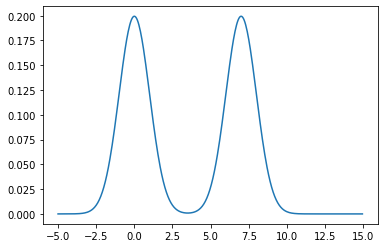

In [ ]:
X = np.arange(-5, 15, step=0.05)
sns.lineplot(X, [test_p(x) for x in X])

In [ ]:
q = ubvi2(test_p, 2, 5)

prev_ip 0
init_point [ 2.55261371 -0.20819884] [[0.60586179 0.        ]
 [0.24018642 0.884011  ]]
x0 [ 5.86064089 -1.15271228  4.92015462  0.          1.60026939  2.55141349]
step 1 [ 5.86064089 -1.15271228] [[4.92015462 0.        ]
 [1.60026939 2.55141349]]
gs [(array([0., 0.]), array([[1., 0.],
       [0., 1.]])), (array([ 5.86064089, -1.15271228]), array([[4.92015462, 0.        ],
       [1.60026939, 2.55141349]])), (array([0., 0.]), array([[1., 0.],
       [0., 1.]])), (array([0., 0.]), array([[1., 0.],
       [0., 1.]])), (array([0., 0.]), array([[1., 0.],
       [0., 1.]])), (array([0., 0.]), array([[1., 0.],
       [0., 1.]]))]
[ 0.39492791 -0.4698938 ]
[ 0.39492791 -0.4698938 ]
d [1.]
Z[:n,:n] [[1.]]
beta [0.]
d [1.]
sqrt 1.0
lambdas [1.]
------------------------------
prev_ip -40.82041826078381


/usr/local/lib/python3.7/dist-packages/scipy/special/_logsumexp.py:118: RuntimeWarning: invalid value encountered in log
  out = np.log(s)


init_point [-0.42017091 -1.79415919] [[0.86663682 0.        ]
 [0.12440413 0.21693065]]
x0 [4.09223353 6.20696058 2.61028366 0.         1.46781418 1.44103553]
step 2 [4.09223353 6.20696058] [[2.61028366 0.        ]
 [1.46781418 1.44103553]]
gs [(array([0., 0.]), array([[1., 0.],
       [0., 1.]])), (array([ 5.86064089, -1.15271228]), array([[4.92015462, 0.        ],
       [1.60026939, 2.55141349]])), (array([4.09223353, 6.20696058]), array([[2.61028366, 0.        ],
       [1.46781418, 1.44103553]])), (array([0., 0.]), array([[1., 0.],
       [0., 1.]])), (array([0., 0.]), array([[1., 0.],
       [0., 1.]])), (array([0., 0.]), array([[1., 0.],
       [0., 1.]]))]
[-0.45705989  1.88088601]
[ 0.39492791 -0.4698938 ]
[-0.45705989  1.88088601]
[-0.45705989  1.88088601]
d [3.28433939e-10 1.00000000e+00]
Z[:n,:n] [[1.         0.13171898]
 [0.13171898 1.        ]]
beta [0.13171898 0.        ]
d [3.28433939e-10 1.00000000e+00]
sqrt 0.9999999999999998
lambdas [-1.73701304e-16  1.00000000e+00]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in reduce
  if __name__ == '__main__':


prev_ip nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in reduce
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


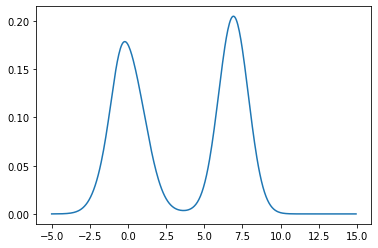

In [ ]:
sns.lineplot(X, [q(x) for x in X])

In [ ]:
a=np.array([[1.,         0.97493371, 0.99999999],
 [0.97493371, 1.,         0.94826202],
 [0.99999999, 0.94826202, 1.        ]])
a.dtype

dtype('float64')

In [ ]:
df = pd.DataFrame({'x': X, 'p': [test_p(x) for x in X], 'q': [q(x) for x in X]})

In [ ]:
sns.lineplot(hue='variable', y='value' x='x', pd.melt(df, ['x']))